# Lab 7: Principal Component Analysis (PCA) vs. Variatioinal Autoencoders (VAEs)

In this lab, we will explore PCA and VAEs.
- **PCA**: Unsupervised dimensionality reduction technique.
- **VAEs**: A generative model with continuous and probabilistic latent representation.

We’ll use the **FashionMNIST** dataset.

- Dataset loading and overview
- PCA
- VAEs
- Conditional VAEs


### FashionMNIST dataset
<div>
<img src="image.png" width="600"/>
</div>


Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [1]:
# Load Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize(28),        # Resize images to 28x28 for consistency
    transforms.Grayscale(num_output_channels=1),  # Ensure 1 channel (grayscale)
    transforms.ToTensor(),        # Convert to tensor (values in [0,1])
])

# Load FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Define DataLoader for training
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, pin_memory=True)

# Print dataset size
print(f"Training set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")

# Define FashionMNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(class_names)


Training set size: 60000, Test set size: 10000
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


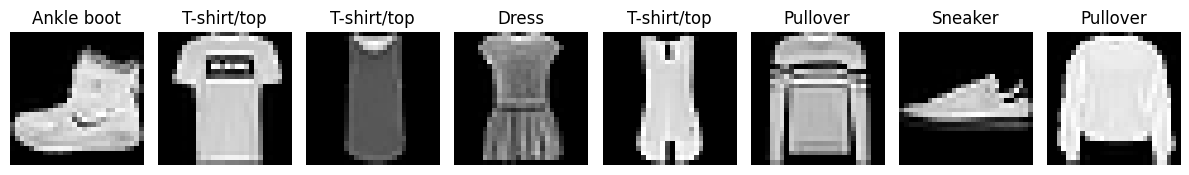

In [3]:
# Visualize some sample images
import matplotlib.pyplot as plt

def show_sample_images(dataset, num_samples=8):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(0), cmap="gray")
        axes[i].axis("off")
        # Add class name as title above each image
        axes[i].set_title(class_names[label], fontsize=12)
    plt.tight_layout()  # Adjust layout to prevent title overlap
    plt.show()

# Show sample images from the dataset
show_sample_images(train_dataset)

# PCA recap

## 1. PCA Definitions: variance maximization

PCA seeks a unit vector $w$ that maximizes the variance of the projected data: $\max_{\|w\|=1} \text{Var}(w^\top x)$
$$\text{Var}(w^\top x) = \mathbb{E}[(w^\top x−\mathbb{E}[w^\top x])^2] = \mathbb{E}[(w^\top (x−\mathbb{E}[x])) (w^\top (x−\mathbb{E}[x])^\top] = w^\top \mathbb{E}[(x - \mathbb{E} [x])(x - \mathbb{E} [x])^\top] w = w^\top \Sigma_x w$$
$\Sigma_x$ is the covariance matrix of data $x$: $\Sigma_x = \mathbb{E}[(x - \mathbb{E} [x])(x - \mathbb{E} [x])^\top]$

The solution to $\max_{\|w\|=1} (w^\top \Sigma_x w)$ is the eigenvector of $\Sigma_x$: $w_1$, with the largest eigenvalue: $\lambda_1$: $w_1^\top \Sigma_x w_1 = \lambda_1$

All of the eigenvectors (solution) make a matrix $W$ such that:
$$W^\top \Sigma_x W = \Lambda$$
where:
  - $W$ contains eigenvectors of $\Sigma_x$.
  - $\Lambda$ is a diagonal matrix of eigenvalues (principal variances).

Then we will project data $x$ onto the principal component directions:
$$z = W^{-1} (x - \mathbb{E} [x])$$


## 2. Connection to variational inference
PCA can be derived as a special case of a probabilistic generative model where:
- The latent variable $z$ follows a Gaussian prior:
$p(z) = N(z; 0, \sigma^2 I^{|z|})$
- The observed data $x$ is modeled as a linear transformation of $z$ plus Gaussian noise:
$p(x|z) = N(x; Wz + b, I^{|x|})$
- The approximate posterior: $q(z; \phi(x_n)) = \mathcal{N}(z; \mu_n, I^{|z|})$

To solve the objective function $J = \frac{1}{N} \sum_n J_n$, we get analytical solution to $\mu_n$:
$$\mu_n = (W^{\top}W + \sigma^{-2}I)^{-1}W^{\top}(x_n - b)$$

**Connection to PCA**.
As $\sigma^2 \to \infty$, meaning there is no prior information:
$$\mu_n = (W^{\top}W)^{-1}W^{\top}(x_n - b)$$
If $W$ is square, invertible:
$$\mu_n = W^{-1}(x_n - b)$$

## PCA Implementation

There are different ways to implement PCA.

### Eigenvalue decomposition (EVD) of covariance matrix:

1. Prepare data and standardize (zero-mean): $N$ samples with dimension of $D$
2. Compute covariance matrix:
   - Calculate the covariance matrix $C = \frac{1}{N-1} X^T X$ (since data is zero-mean)
   - $C$ will be a $D \times D$ matrix
3. Eigen-decomposition:
   - Compute the eigenvalues and eigenvectors of $C$
   - The eigenvectors corresponding to the largest eigenvalues are the principal components
4. Dimensionality reduction:
   - To project onto the top-$k$ components, take the first $k$ eigenvectors
   - Transform $X$ to a reduced representation $Z = X W_k$
   - Reconstruct approximately as $\hat{X} = Z W_k^T$ (adding back the mean)

### Singular value decomposition (SVD)

Instead of computing the covariance matrix, apply singular value decomposition (SVD) to the centered data matrix $X$
$$X = USV^\top$$
where:
- $U$ contains the left singular vectors (not used in PCA).
- $S$ is a diagonal matrix of singular values, which are eigenvalues of covariance matrix.
- $V$ contains the right singular vectors, which correspond to eigenvectors of covariance matrix.

SVD is more numerically stable than EVD, and avoids explicit computation of covariance matrix, making it better for high-dimensional data and large datasets.

### Expectation-maximization (EM) algorithm

Using the connection to variational inference, we can use the EM algorithm to find $W$ and $b$.
$$p(x|z) = N(x; Wz + b, I^{|x|})$$
EM Algorithm Steps:
- E-step: Compute the posterior mean of the latent variable
$$\mu_n = (W^{\top}W + \sigma^{-2}I)^{-1}W^{\top}(x_n - b)$$
- M-step: Update $W$ and $b$
$$W = 
    \left(\frac{1}{N} \sum_{n=1}^N (x_n - b)\mu_n^\top \right)
    \left(I + \frac{1}{N}\sum_{n=1}^N \mu_n \mu_n^\top\right)^{-1}$$
$$b = \frac{1}{N} \sum_{n=1}^N \left( W \mu_n - x_n\right)$$
- Repeat until convergence.

In [4]:
# Implementation using EVD
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Subset

# Select a subset of the FashionMNIST dataset for PCA (e.g., first 1000 images)
pca_subset_size = 1000
pca_indices = list(range(pca_subset_size))
pca_subset = Subset(train_dataset, pca_indices)

# Flatten images and create data matrix X
X_list = []
for img, _ in pca_subset:
    X_list.append(img.view(-1))  # Flatten image (28x28 -> 784)
X = torch.stack(X_list)  # Shape: (1000, 784)
X = X.to(device)  # Move to GPU for faster computation

# Step 1: Standardize the data (zero mean)
mean_vector = X.mean(dim=0)  # Compute mean for each pixel across all images
X_centered = X - mean_vector  # Subtract mean

# Step 2: Compute covariance matrix
N, D = X_centered.shape
cov_matrix = (X_centered.T @ X_centered) / (N - 1)  # (D x D)

# Step 3: Eigen-decomposition of covariance matrix
eig_vals, eig_vecs = torch.linalg.eigh(cov_matrix)  # Eigenvalues in ascending order

# Step 4: Sort eigenvalues and eigenvectors in descending order
eig_vals, indices = torch.sort(eig_vals, descending=True)
eig_vecs = eig_vecs[:, indices]  # Sorted eigenvectors

print("Top 5 eigenvalues:", eig_vals[:5])

# Step 5: Project onto the first k principal components
k = 50  # Number of principal components to retain
Wk = eig_vecs[:, :k]  # Top-k eigenvectors (D x k)
Z = X_centered @ Wk  # Projected data (1000, k)

# Reconstruct images from the reduced space
X_reconstruct = Z @ Wk.T + mean_vector  # Approximate original images


Top 5 eigenvalues: tensor([20.2465, 12.0857,  3.9225,  3.6875,  2.7143], device='cuda:0')


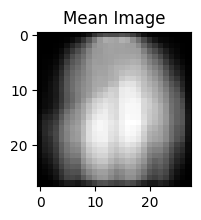

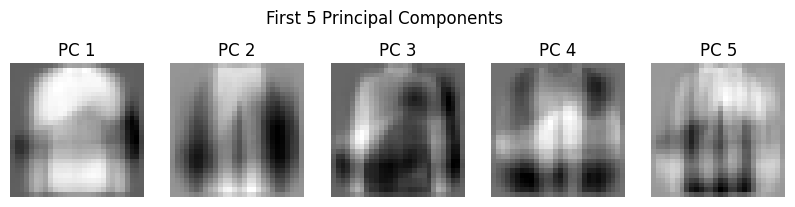

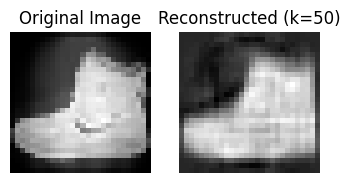

In [5]:
# Visualize
# Move data back to CPU for visualization
mean_vector_cpu = mean_vector.cpu()
eig_vecs_cpu = eig_vecs.cpu()
X_centered_cpu = X_centered.cpu()

# Compute and display the mean image
mean_img = mean_vector_cpu.reshape(28, 28).numpy()
plt.figure(figsize=(2,2))
plt.title("Mean Image")
plt.imshow(mean_img, cmap='gray')
plt.show()

# Display the first 5 principal components (eigenimages)
fig, axes = plt.subplots(1, 5, figsize=(10,2))
for i in range(5):
    pc_img = eig_vecs_cpu[:, i].reshape(28, 28).numpy()
    axes[i].imshow(pc_img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"PC {i+1}", fontsize=12)
plt.suptitle("First 5 Principal Components", fontsize=12, y=1.1)
plt.show()

# Choose a sample image and reconstruct it using top-k components
sample_idx = 0  # First image in the subset
x_original = X[sample_idx] + mean_vector  # Add mean back
z_sample = torch.matmul(X_centered[sample_idx], Wk)  # Project onto top-k components
x_reconstruct = torch.matmul(z_sample, Wk.T) + mean_vector  # Reconstruct

# Reshape for visualization
x_original_img = x_original.reshape(28, 28).cpu().numpy()
x_reconstruct_img = x_reconstruct.reshape(28, 28).cpu().numpy()

plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(x_original_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title(f"Reconstructed (k={k})")
plt.imshow(x_reconstruct_img, cmap='gray')
plt.axis('off')

plt.show()


# VAEs recap

### PCA limitation.

PCA assumes linearity and models only Gaussian-distributed data, making it unsuitable for capturing complex, nonlinear structures in real-world datasets.

### VAEs is a nonlinear extension of PCA.

VAEs introduce nonlinear mappings through neural networks:
$$p(x|z) = N(x|F(z;\theta), I)$$
where $F(z;\theta)$ is a neural network that learns complex, nonlinear relationships.

### Key Components.

- Latent variable model $G(x)$.
    
    Since we do not have an analytic solution to $\mu_n$ in $q(z; \phi(x_n)) = \mathcal{N}(z; \mu_n, I^{|z|})$, we must store and update the $\mu_n$ for every training sample during Monte Carlo sampling, which becomes infeasible for large datasets.
    
    Instead, we use a neural network $G(x)$ (encoder): 
    $$\mu_n = G(x_n;\theta_G)$$
    - Avoid large storage requirement
    - Enables generalization

- Reparametrization trick.

    We need to do sampling during training: $z \sim q(z)$, but We cannot backpropagate through the sampling operation because it is a non-differentiable operation.
    To enable gradient computation through sampling, VAEs employ:
    $$z = \mu + \sigma\epsilon$$
    where $\epsilon \sim N(0, I)$.
    
    This allows gradients to flow through the latent variables during training.

- Loss Function.
    
    VAEs optimize the variational lower bound consisting of two terms:
    $$J_n = \mathbb{E}_{z \sim q_n(z; G(x_n; \theta_G), \sigma^2)} 
    \left[ -\frac{1}{2} \| x_n - F(z;\theta) \|^2 - \frac{|x|}{2} \log 2\pi\right] - \frac{1}{2} \left[ \frac{K + \|G(x_n; \theta_G)\|^2}{\sigma^2} - K + 2K \ln(\sigma) \right]$$
    A single sample estimate:
    $$\tilde{J}_n = -\frac{1}{2}\| x_n - F(G(x_n; \theta_G)+\sigma \epsilon; \theta) \|^2 - \frac{1}{2 \sigma^2} \| G(x_n; \theta_G)\|^2 + \mathrm{const.}$$
    where:
    - First term: Reconstruction loss
    - Second term: KL divergence loss: minimizing L2 norm - ensuring the space of the latent variable $z$, as tightly as possible. Otherwise, sampling $z \sim p(z)$ would result in invalid or meaningless prediction.



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = 28 * 28  # FashionMNIST images are 28x28

        # Encoder: Fully connected layers
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten image to 784
            nn.Linear(self.img_size, 512),
            nn.ReLU(),
            nn.Linear(512, 2 * latent_dim)  # Outputs mu and logvar concatenated
        )

        # Decoder: Fully connected layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, self.img_size),
            nn.Sigmoid()  # Sigmoid to output values in [0,1] for BCE loss
        )

    def encode(self, x):
        """Encodes input images into latent mean and log-variance vectors."""
        h = self.encoder(x)  # (batch, 2*latent_dim)
        mu = h[:, :self.latent_dim]
        logvar = h[:, self.latent_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Samples z from N(mu, sigma^2) using the reparameterization trick."""
        std = torch.exp(0.5 * logvar)  # Compute standard deviation
        eps = torch.randn_like(std)  # Sample epsilon ~ N(0, I)
        z = mu + eps * std  # Reparameterization trick
        return z

    def decode(self, z):
        """Decodes latent vector z to reconstructed image."""
        x_reconst_flat = self.decoder(z)  # Output is flattened image
        x_reconst = x_reconst_flat.view(-1, 1, 28, 28)  # Reshape to (batch, 1, 28, 28)
        return x_reconst

    def forward(self, x):
        #TODO
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)
        return x_reconst, mu, logvar

# Instantiate the VAE model
latent_dim = 20  # Adjustable latent dimension
vae = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

print(f"VAE model initialized with latent dimension: {latent_dim}")


Using device: cuda
VAE model initialized with latent dimension: 20


In [7]:
def loss_function(recon_x, x, mu, logvar):
    """Computes the VAE loss: Reconstruction loss + KL divergence"""
    # Reconstruction loss (BCE)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0)
    
    # KL divergence loss (per batch average)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    return recon_loss + kl_loss


In [8]:
# Load FashionMNIST dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Training loop
num_epochs = 20
vae.train()
for epoch in range(1, num_epochs + 1):
    total_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 271.8910
Epoch [2/20], Loss: 250.9679
Epoch [3/20], Loss: 246.9925
Epoch [4/20], Loss: 245.1385
Epoch [5/20], Loss: 243.9997
Epoch [6/20], Loss: 243.2507
Epoch [7/20], Loss: 242.6477
Epoch [8/20], Loss: 242.1254
Epoch [9/20], Loss: 241.6689
Epoch [10/20], Loss: 241.3047
Epoch [11/20], Loss: 241.0403
Epoch [12/20], Loss: 240.7926
Epoch [13/20], Loss: 240.5512
Epoch [14/20], Loss: 240.3641
Epoch [15/20], Loss: 240.1504
Epoch [16/20], Loss: 239.9744
Epoch [17/20], Loss: 239.8303
Epoch [18/20], Loss: 239.7329
Epoch [19/20], Loss: 239.6099
Epoch [20/20], Loss: 239.4889


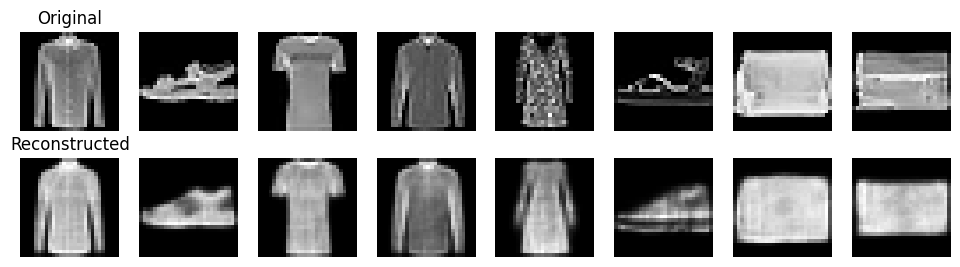

In [9]:
# Switch to evaluation mode
vae.eval()

# Load a few test images
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
images, _ = next(iter(test_loader))
images = images.to(device)

# Get reconstructions
with torch.no_grad():
    recon_images, _, _ = vae(images)

# Move to CPU for visualization
images = images.cpu()
recon_images = recon_images.cpu()

# Plot original vs reconstructed
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(images[i].squeeze(0), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_images[i].squeeze(0), cmap='gray')
    axes[1, i].axis('off')
axes[0,0].set_title("Original")
axes[1,0].set_title("Reconstructed")
plt.show()


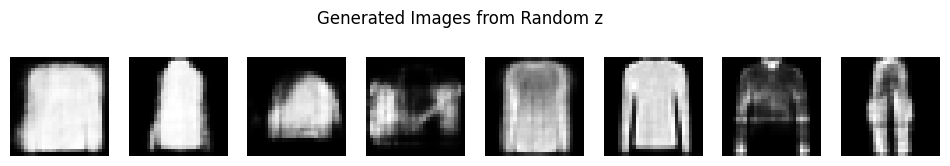

In [10]:
# Generate new images by sampling random latent vectors
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)  # 8 random latent vectors
    gen_images = vae.decode(z).cpu()

# Plot generated images
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(gen_images[i].squeeze(0).numpy(), cmap='gray')
    axes[i].axis('off')
plt.suptitle("Generated Images from Random z")
plt.show()


# Conditional VAEs

To extend VAE to a conditional VAE (CVAE), we need to condition both the encoder and decoder on the label, $c$.

- Modify the encoder: Instead of encoding only the image $x$, also encode the label $c$.

- Modify the decoder: Instead of decoding only the latent vector $z$, also pass the label $c$ to generate a conditioned image.

- Modify the reparameterization trick: The sampling process remains the same, but $z$ now depends on both $x$ and $c$.

- Modify the forward pass: Ensure that labels $c$ are passed through the model correctly.

In [11]:
# Conditional VAEs
# label c concatenate to image, also sending to q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Conditional VAE model
class CVAE(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = 28 * 28  # FashionMNIST images are 28x28
        self.num_classes = num_classes  # Number of labels

        # One-hot embedding for labels
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        #TODO
        # Encoder: Fully connected layers with conditioning
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten image to 784
            nn.Linear(self.img_size + num_classes, 512),  # Concatenate label
            nn.ReLU(),
            nn.Linear(512, 2 * latent_dim)  # Outputs mu and logvar concatenated
        )
        #TODO
        # Decoder: Fully connected layers with conditioning
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 512),  # Concatenate label
            nn.ReLU(),
            nn.Linear(512, self.img_size),
            nn.Sigmoid()  # Sigmoid to output values in [0,1] for BCE loss
        )

    def encode(self, x, c):
        """Encodes input images and labels into latent mean and log-variance vectors."""
        c_embed = self.label_embedding(c)  # Convert labels to embeddings
        c_embed = c_embed.view(c.shape[0], -1)  # Reshape to match batch size
        x = torch.cat([x.view(x.shape[0], -1), c_embed], dim=1)  # Concatenate
        h = self.encoder(x)  # (batch, 2*latent_dim)
        mu = h[:, :self.latent_dim]
        logvar = h[:, self.latent_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Samples z from N(mu, sigma^2) using the reparameterization trick."""
        std = torch.exp(0.5 * logvar)  # Compute standard deviation
        eps = torch.randn_like(std)  # Sample epsilon ~ N(0, I)
        z = mu + eps * std  # Reparameterization trick
        return z

    def decode(self, z, c):
        """Decodes latent vector z and label c to reconstructed image."""
        c_embed = self.label_embedding(c)  # Convert labels to embeddings
        c_embed = c_embed.view(c.shape[0], -1)
        z = torch.cat([z, c_embed], dim=1)  # Concatenate latent vector and label
        x_reconst_flat = self.decoder(z)  # Output is flattened image
        x_reconst = x_reconst_flat.view(-1, 1, 28, 28)  # Reshape to (batch, 1, 28, 28)
        return x_reconst

    def forward(self, x, c):
        #TODO
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z, c)
        return x_reconst, mu, logvar

# Instantiate the CVAE model
latent_dim = 20  # Adjustable latent dimension
num_classes = 10  # Number of classes in FashionMNIST
cvae = CVAE(latent_dim, num_classes).to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

print(f"CVAE model initialized with latent dimension: {latent_dim}, and {num_classes} classes.")


Using device: cuda
CVAE model initialized with latent dimension: 20, and 10 classes.


In [12]:
# Load FashionMNIST dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Training loop
num_epochs = 20
cvae.train()
for epoch in range(1, num_epochs + 1):
    total_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = cvae(images, labels)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 266.6259
Epoch [2/20], Loss: 246.6577
Epoch [3/20], Loss: 242.4630
Epoch [4/20], Loss: 240.5460
Epoch [5/20], Loss: 239.3584
Epoch [6/20], Loss: 238.5765
Epoch [7/20], Loss: 238.0061
Epoch [8/20], Loss: 237.4808
Epoch [9/20], Loss: 237.1049
Epoch [10/20], Loss: 236.8171
Epoch [11/20], Loss: 236.5550
Epoch [12/20], Loss: 236.3373
Epoch [13/20], Loss: 236.1368
Epoch [14/20], Loss: 235.9938
Epoch [15/20], Loss: 235.7891
Epoch [16/20], Loss: 235.7248
Epoch [17/20], Loss: 235.5645
Epoch [18/20], Loss: 235.3646
Epoch [19/20], Loss: 235.3191
Epoch [20/20], Loss: 235.2216


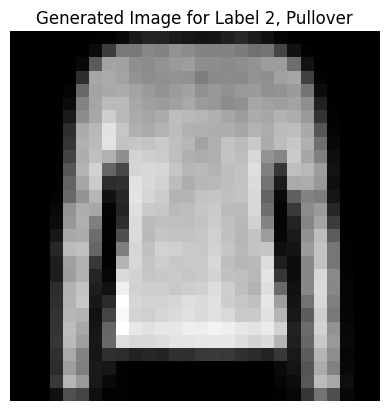

In [14]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set model to evaluation mode
cvae.eval()

# Sample a random latent vector
z_sample = torch.randn(1, latent_dim).to(device)

# Choose a label (e.g., class 3)
label = torch.tensor([2]).to(device)

# Generate an image
with torch.no_grad():
    generated_image = cvae.decode(z_sample, label).cpu()

# Plot the generated image
plt.imshow(generated_image.squeeze(0).squeeze(0), cmap="gray")
plt.title(f"Generated Image for Label {label.item()}, {class_names[label.item()]}")
plt.axis("off")
plt.show()
